### Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report , roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

### Data Loading and Preprocessing 

In [2]:
docs = pd.read_csv("Datasets\smsspamcollection.csv",header=None,names = ['Class','SMS'])

In [3]:
docs

,Class,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Checking the percentage of Ham & Spam distribution class

In [4]:
docs.Class.value_counts(normalize=True)

Class
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

### Spam Class is around 13 percent in the data since the dataset is imbalanced (only 13% spam), we can use SMOTE (Synthetic Minority Over-sampling Technique) to balance it by generating synthetic spam samples.

### Convert labels to 0 (ham) and 1 (spam)

In [5]:
docs.Class = docs.Class.map({'ham':0,'spam':1})

In [6]:
docs.head()

,Class,SMS
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Text Processing 

In [7]:
def cleaning_text(text):
    #converting to lowercase first 
    text = text.lower()
    # removing any special characters -> substutuing the special characters with blank
    text = re.sub(r'[^a-z0-9]',' ',text)
    return text

In [8]:
docs['SMS'] = docs['SMS'].apply(cleaning_text)

In [9]:
# checking the top 5 records 
docs['SMS'].head()

0    go until jurong point  crazy   available only ...
1                        ok lar    joking wif u oni   
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor    u c already then say   
4    nah i don t think he goes to usf  he lives aro...
Name: SMS, dtype: object

### Feature Extraction using count vectorizer

In [10]:
# usign stopwords english in order to remove the irrelevant words and allowing max words in vocaulary to be 5k
vectorizer = CountVectorizer(stop_words='english', max_features=5000)

### Splitting the dataset into X and y

In [11]:
X = docs['SMS']
y = docs.Class

### Splitting the data into train and test set

In [12]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=21)

In [13]:
print(f"Training Data Shape {X_train.shape} and Test Data Shape {X_test.shape}")

Training Data Shape (4457,) and Test Data Shape (1115,)


### Applying transformation using vectorizer 

In [14]:
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

### Applying SMOTE on the training set to create the synthetic data

In [15]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [16]:
print(f"X_train_transformed shape {X_train_transformed.shape} , X_train_resampled shape {X_train_resampled.shape}")

X_train_transformed shape (4457, 5000) , X_train_resampled shape (7730, 5000)


### Model Building 

In [17]:
mnb = MultinomialNB()
mnb.fit(X_train_resampled, y_train_resampled)
y_pred_mnb = mnb.predict(X_test_transformed)
# taking the probaility of the spam class
y_pred_prob_mnb = mnb.predict_proba(X_test_transformed)[:, 1]

In [18]:
bnb = BernoulliNB()
bnb.fit(X_train_resampled, y_train_resampled)
y_pred_bnb = bnb.predict(X_test_transformed)
# taking the probaility of the spam class
y_pred_prob_bnb = bnb.predict_proba(X_test_transformed)[:, 1]

## Model Evaluation

In [19]:
print("Multinomial Naïve Bayes:")
print(classification_report(y_test, y_pred_mnb))
print("Accuracy:", accuracy_score(y_test, y_pred_mnb))

print("\nBernoulli Naïve Bayes:")
print(classification_report(y_test, y_pred_bnb))
print("Accuracy:", accuracy_score(y_test, y_pred_bnb))

Multinomial Naïve Bayes:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       960
           1       0.90      0.94      0.92       155

    accuracy                           0.98      1115
   macro avg       0.94      0.96      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy: 0.9766816143497757

Bernoulli Naïve Bayes:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       960
           1       0.92      0.95      0.93       155

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy: 0.9811659192825112


### ROC Curves

In [20]:
fpr_mnb, tpr_mnb, thresholds = roc_curve(y_test, y_pred_prob_mnb)
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)

In [21]:
fpr_bnb, tpr_bnb, _ = roc_curve(y_test, y_pred_prob_bnb)
roc_auc_bnb = auc(fpr_bnb, tpr_bnb)

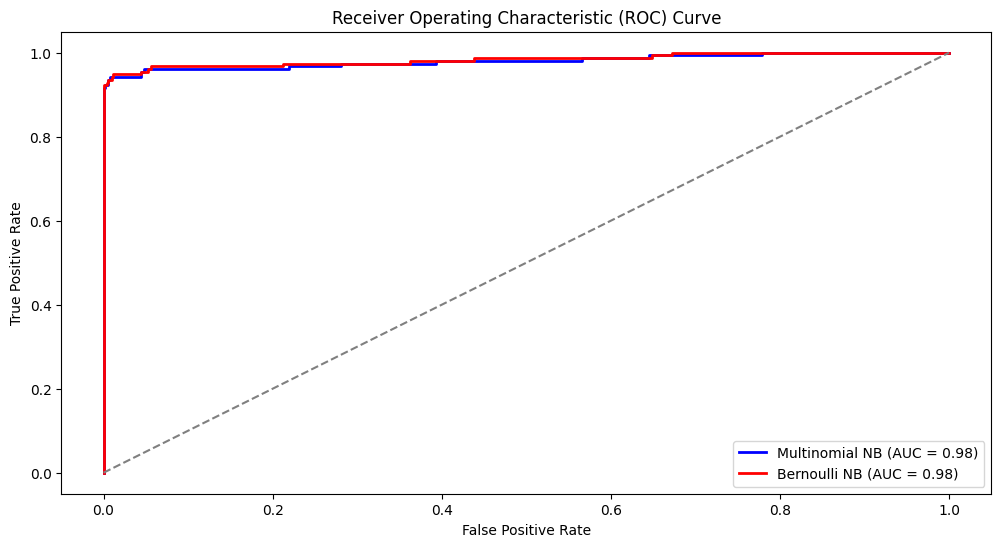

In [22]:
plt.figure(figsize=(12,6))
plt.plot(fpr_mnb, tpr_mnb, color='blue', lw=2, label='Multinomial NB (AUC = %0.2f)' % roc_auc_mnb)
plt.plot(fpr_bnb, tpr_bnb, color='red', lw=2, label='Bernoulli NB (AUC = %0.2f)' % roc_auc_bnb)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Testing on New Sentences 

In [23]:
def predict_spam(messages):
    messages = [cleaning_text(msg) for msg in messages]
    msg_vectors = vectorizer.transform(messages)
    predictions = mnb.predict(msg_vectors)
    return ["Spam" if pred == 1 else "Ham" for pred in predictions]

In [24]:
test_messages = [
    "Congratulations! You have won a free lottery. Click here to claim.",
    "Hey, are we still on for dinner tonight?",
    "Urgent! Your account has been compromised. Reset your password now.",
    "Can you send me the assignment notes?",
    "Lets go for shopping",
    "Clink on the link below to get discount"
]

In [25]:
results = predict_spam(test_messages)

In [26]:
results

['Spam', 'Ham', 'Spam', 'Spam', 'Ham', 'Spam']

In [27]:
for msg, res in zip(test_messages, results):
    print(f"Message: {msg}\nPrediction: {res}\n")

Message: Congratulations! You have won a free lottery. Click here to claim.
Prediction: Spam

Message: Hey, are we still on for dinner tonight?
Prediction: Ham

Message: Urgent! Your account has been compromised. Reset your password now.
Prediction: Spam

Message: Can you send me the assignment notes?
Prediction: Spam

Message: Lets go for shopping
Prediction: Ham

Message: Clink on the link below to get discount
Prediction: Spam

